In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostClassifier
import seaborn as sns

In [14]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [15]:
df = pd.concat([train, test], ignore_index=True)

In [16]:
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0.0
1,72,25.85,1872.2,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0.0
2,1,75.90,75.9,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1.0
3,32,79.30,2570,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0.0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0.0


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ClientPeriod              7043 non-null   int64  
 1   MonthlySpending           7043 non-null   float64
 2   TotalSpent                7043 non-null   object 
 3   Sex                       7043 non-null   object 
 4   IsSeniorCitizen           7043 non-null   int64  
 5   HasPartner                7043 non-null   object 
 6   HasChild                  7043 non-null   object 
 7   HasPhoneService           7043 non-null   object 
 8   HasMultiplePhoneNumbers   7043 non-null   object 
 9   HasInternetService        7043 non-null   object 
 10  HasOnlineSecurityService  7043 non-null   object 
 11  HasOnlineBackup           7043 non-null   object 
 12  HasDeviceProtection       7043 non-null   object 
 13  HasTechSupportAccess      7043 non-null   object 
 14  HasOnlin

In [18]:
df.describe()

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn
count,7043.000000,7043.000000,7043.000000,5282.000000
mean,32.371149,64.761692,0.162147,0.262022
std,24.559481,30.090047,0.368612,0.439776
min,0.000000,18.250000,0.000000,0.000000
25%,9.000000,35.500000,0.000000,0.000000
50%,29.000000,70.350000,0.000000,0.000000
75%,55.000000,89.850000,0.000000,1.000000
max,72.000000,118.750000,1.000000,1.000000


In [19]:
df['TotalSpent'] = pd.to_numeric(df['TotalSpent'], errors='coerce')

In [20]:
train['TotalSpent'] = pd.to_numeric(train['TotalSpent'], errors='coerce')
test['TotalSpent'] = pd.to_numeric(test['TotalSpent'], errors='coerce')

In [60]:
cat_cols = train.select_dtypes(include=['object']).columns.tolist()
int_cols = train.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()

In [61]:
int_cols.remove('Churn')

In [62]:
df.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn',
       'HasInternet', 'NumAddServices', 'IsLongTerm', 'AvgMonthly'],
      dtype='object')

In [24]:
df

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,HasOnlineSecurityService,HasOnlineBackup,HasDeviceProtection,HasTechSupportAccess,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,No,Mailed check,0.0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Credit card (automatic),0.0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,No,No,No,Yes,No,No,Month-to-month,Yes,Electronic check,1.0
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,No,No,Month-to-month,No,Mailed check,0.0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Two year,No,Credit card (automatic),0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,71,105.15,7555.00,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Two year,Yes,Bank transfer (automatic),NaN
7039,13,20.85,272.35,Female,0,Yes,Yes,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,NaN
7040,2,91.45,171.45,Male,0,Yes,No,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,No,Month-to-month,Yes,Electronic check,NaN
7041,19,89.10,1620.80,Female,0,Yes,No,Yes,Yes,Fiber optic,No,Yes,No,No,No,Yes,Month-to-month,Yes,Electronic check,NaN


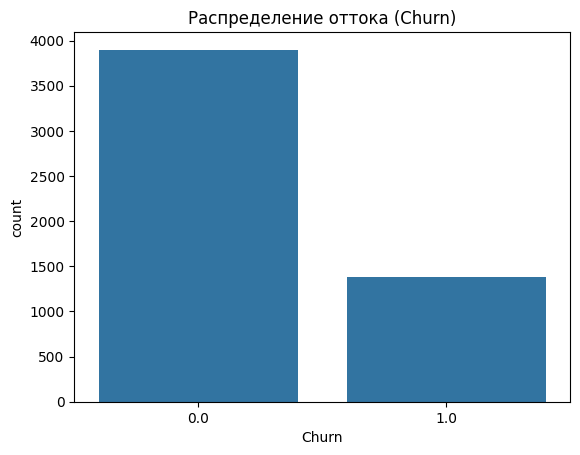

In [25]:
sns.countplot(data=df, x='Churn')
plt.title('Распределение оттока (Churn)')
plt.show()

In [26]:
int_cols

['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'IsSeniorCitizen']

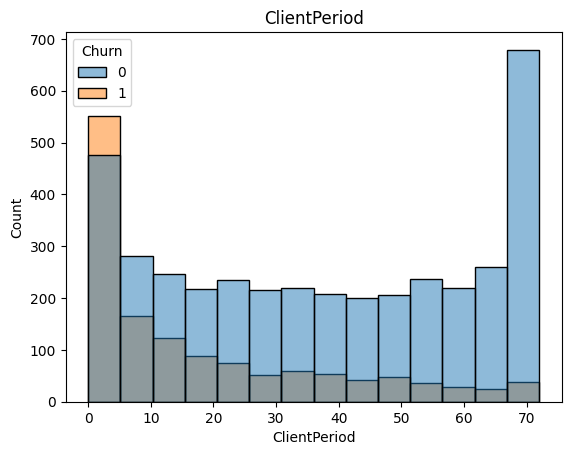

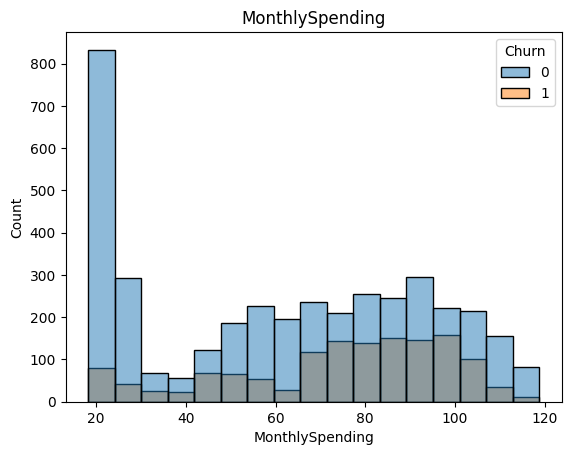

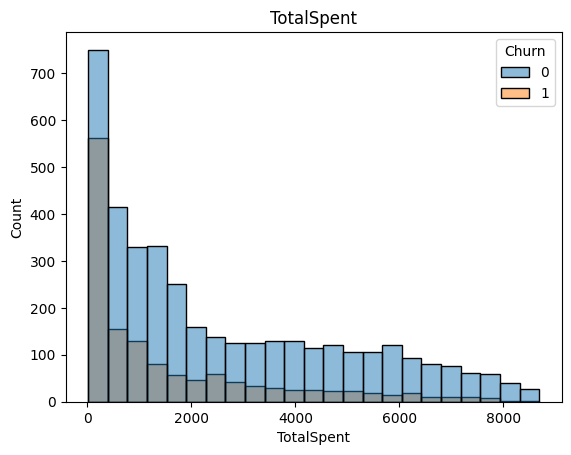

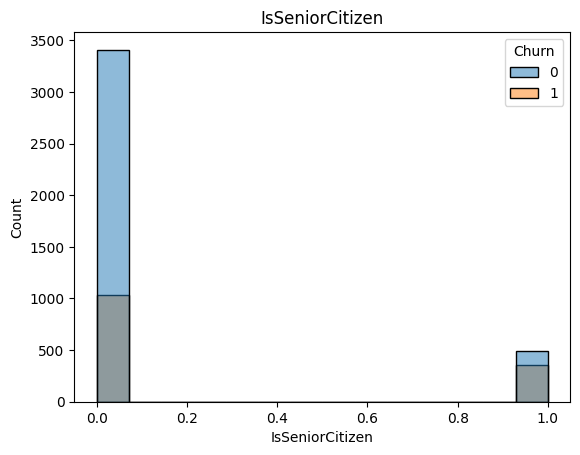

In [27]:
for x in int_cols:
    sns.histplot(data=train, x=x, hue="Churn")
    plt.title(f'{x}')
    plt.show()

In [28]:
df['TotalSpent'] = df['TotalSpent'].replace(r'^\s*$', np.nan, regex=True)
df['TotalSpent'] = pd.to_numeric(df['TotalSpent'], errors='coerce')

# Заполним пропуски медианой (можно и средним, но медиана устойчивее к выбросам)
df['TotalSpent'].fillna(df['TotalSpent'].median(), inplace=True)

C:\Users\Trebias\AppData\Local\Temp\ipykernel_3600\1648063234.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['TotalSpent'].fillna(df['TotalSpent'].median(), inplace=True)


In [29]:
df.columns

Index(['ClientPeriod', 'MonthlySpending', 'TotalSpent', 'Sex',
       'IsSeniorCitizen', 'HasPartner', 'HasChild', 'HasPhoneService',
       'HasMultiplePhoneNumbers', 'HasInternetService',
       'HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
       'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription',
       'HasContractPhone', 'IsBillingPaperless', 'PaymentMethod', 'Churn'],
      dtype='object')

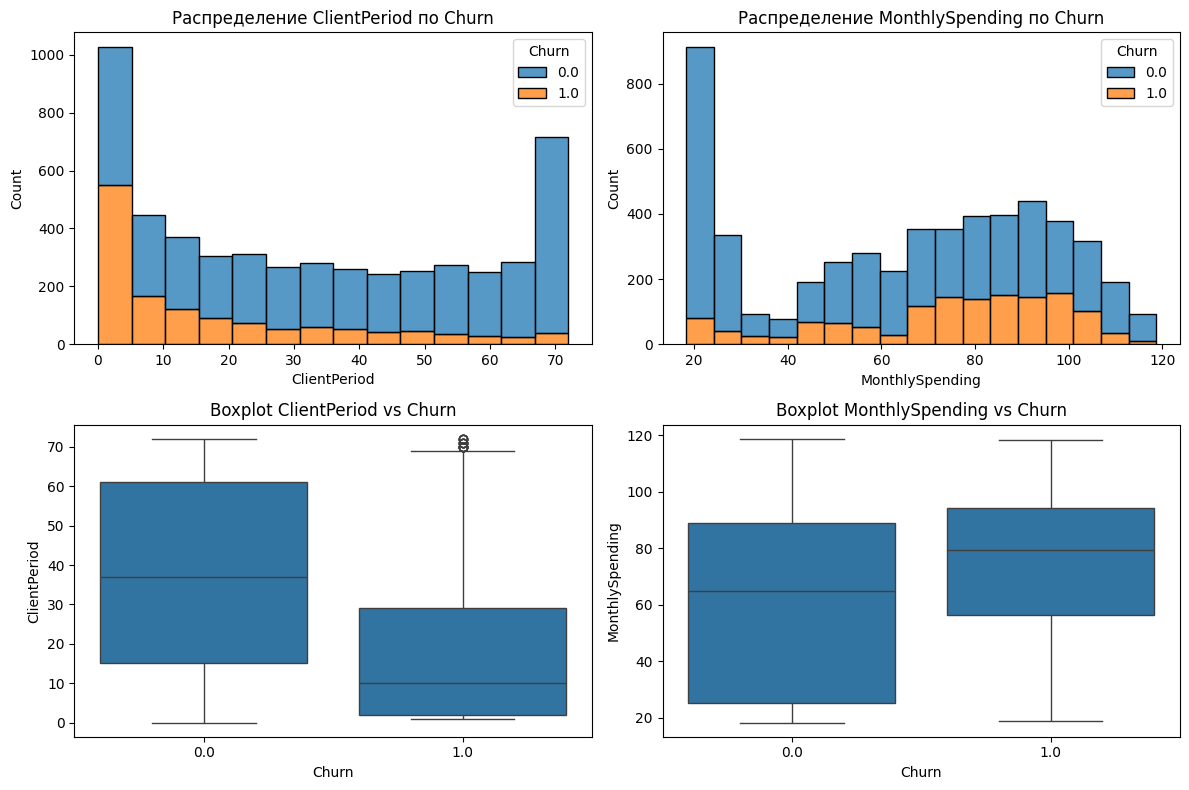

In [30]:
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Tenure
sns.histplot(data=df, x='ClientPeriod', hue='Churn', multiple='stack', ax=axes[0, 0])
axes[0, 0].set_title('Распределение ClientPeriod по Churn')

# MonthlyCharges
sns.histplot(data=df, x='MonthlySpending', hue='Churn', multiple='stack', ax=axes[0, 1])
axes[0, 1].set_title('Распределение MonthlySpending по Churn')

# Boxplots
sns.boxplot(data=df, x='Churn', y='ClientPeriod', ax=axes[1, 0])
axes[1, 0].set_title('Boxplot ClientPeriod vs Churn')

sns.boxplot(data=df, x='Churn', y='MonthlySpending', ax=axes[1, 1])
axes[1, 1].set_title('Boxplot MonthlySpending vs Churn')

plt.tight_layout()
plt.show()

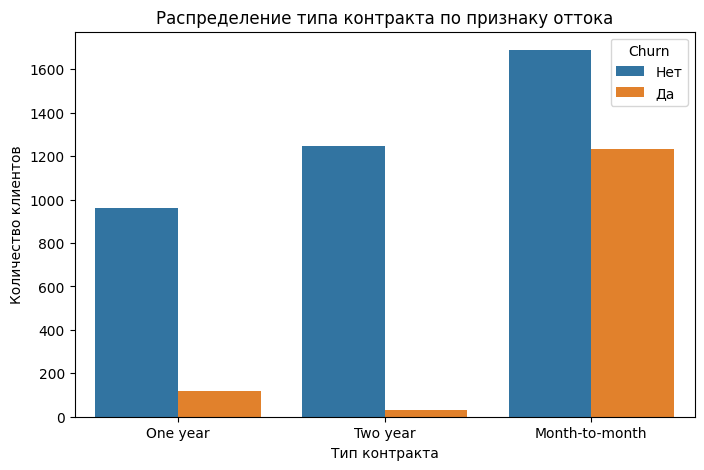

In [31]:
plt.figure(figsize=(8, 5))
sns.countplot(data=df, x='HasContractPhone', hue='Churn')
plt.title('Распределение типа контракта по признаку оттока')
plt.xlabel('Тип контракта')
plt.ylabel('Количество клиентов')
plt.legend(title='Churn', labels=['Нет', 'Да'])
plt.show()

In [32]:
# Пример новых признаков:
df['HasInternet'] = (df['HasInternetService'] != 'No').astype(int)
df['NumAddServices'] = (df[['HasOnlineSecurityService', 'HasOnlineBackup', 'HasDeviceProtection',
                           'HasTechSupportAccess', 'HasOnlineTV', 'HasMovieSubscription']] == 'Yes').sum(axis=1)
df['IsLongTerm'] = (df['ClientPeriod'] > 48).astype(int)
df['AvgMonthly'] = df['TotalSpent'] / df['TotalSpent'].replace(0, 1)

Рассчитаны VIF (Variance Inflation Factor) для всех числовых признаков.
Установлено высокое VIF для TotalCharges (~25), связанного с tenure и MonthlyCharges.

In [33]:
df.head()

,ClientPeriod,MonthlySpending,TotalSpent,Sex,IsSeniorCitizen,HasPartner,HasChild,HasPhoneService,HasMultiplePhoneNumbers,HasInternetService,...,HasOnlineTV,HasMovieSubscription,HasContractPhone,IsBillingPaperless,PaymentMethod,Churn,HasInternet,NumAddServices,IsLongTerm,AvgMonthly
0,55,19.50,1026.35,Male,0,Yes,Yes,Yes,No,No,...,No internet service,No internet service,One year,No,Mailed check,0.0,0,0,1,1.0
1,72,25.85,1872.20,Male,0,Yes,No,Yes,Yes,No,...,No internet service,No internet service,Two year,No,Credit card (automatic),0.0,0,0,1,1.0
2,1,75.90,75.90,Male,0,No,No,Yes,No,Fiber optic,...,No,No,Month-to-month,Yes,Electronic check,1.0,1,1,0,1.0
3,32,79.30,2570.00,Female,1,Yes,No,Yes,Yes,Fiber optic,...,No,No,Month-to-month,No,Mailed check,0.0,1,1,0,1.0
4,60,115.25,6758.45,Female,0,Yes,Yes,Yes,Yes,Fiber optic,...,Yes,Yes,Two year,No,Credit card (automatic),0.0,1,6,1,1.0


<Axes: xlabel='IsLongTerm', ylabel='count'>

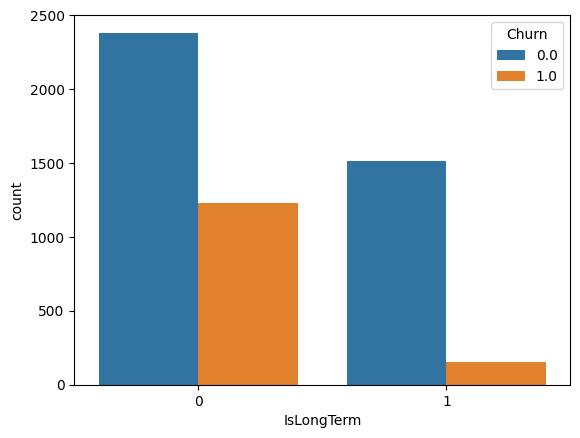

In [34]:
sns.countplot(data=df, x='IsLongTerm', hue='Churn')

## Инсайты

1. Чем дольше клиенты пользуются сервисом, тем меньше вероятность того, что клиент уйдет
2. Чем больше клиент тратит в сервисе в месяц, тем больше вероятность того, что он его покинет
3. Клиенты с помесячным контрактом (Month-to-month) демонстрируют значительно более высокий уровень оттока по сравнению с теми, у кого годовой или двухлетний контракт.


In [64]:
df_encoded = pd.get_dummies(df, columns=cat_cols, drop_first=True)

In [67]:
df_encoded.astype('Float64')

,ClientPeriod,MonthlySpending,TotalSpent,IsSeniorCitizen,Churn,HasInternet,NumAddServices,IsLongTerm,AvgMonthly,Sex_Male,...,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,55.0,19.5,1026.35,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
1,72.0,25.85,1872.2,0.0,0.0,0.0,0.0,1.0,1.0,1.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0
2,1.0,75.9,75.9,0.0,1.0,1.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
3,32.0,79.3,2570.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,60.0,115.25,6758.45,0.0,0.0,1.0,6.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,71.0,105.15,7555.0,0.0,<NA>,1.0,4.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0
7039,13.0,20.85,272.35,0.0,<NA>,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
7040,2.0,91.45,171.45,0.0,<NA>,1.0,2.0,0.0,1.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
7041,19.0,89.1,1620.8,0.0,<NA>,1.0,2.0,0.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0


<Axes: >

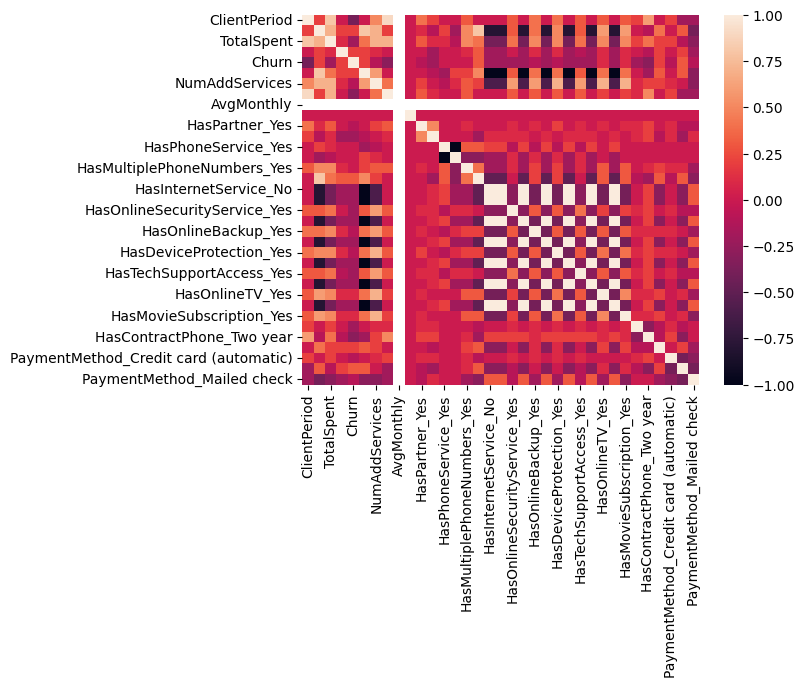

In [36]:
sns.heatmap(df_encoded.corr().round(1), annot=False)

In [37]:
# Замечаем высокую корреляцию между ClientPeriod и TotalSpent
df.loc[:,['ClientPeriod', 'TotalSpent']].corr() 

,ClientPeriod,TotalSpent
ClientPeriod,1.000000,0.825464
TotalSpent,0.825464,1.000000


In [38]:
df_encoded = df_encoded.drop('TotalSpent', axis=1)

In [39]:
cat_cols = df_encoded.select_dtypes(include=['object']).columns.tolist()
int_cols = df_encoded.select_dtypes(include=['float64', 'int64', 'int32']).columns.tolist()
int_cols.remove("Churn")

In [40]:
scaler = StandardScaler()
df_encoded[int_cols] = scaler.fit_transform(df_encoded[int_cols])

In [41]:
df_encoded

,ClientPeriod,MonthlySpending,IsSeniorCitizen,Churn,HasInternet,NumAddServices,IsLongTerm,AvgMonthly,Sex_Male,HasPartner_Yes,...,HasOnlineTV_No internet service,HasOnlineTV_Yes,HasMovieSubscription_No internet service,HasMovieSubscription_Yes,HasContractPhone_One year,HasContractPhone_Two year,IsBillingPaperless_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0.921455,-1.504315,-0.439916,0.0,-1.901403,-1.103033,1.464787,0.0,True,True,...,True,False,True,False,True,False,False,False,False,True
1,1.613701,-1.293267,-0.439916,0.0,-1.901403,-1.103033,1.464787,0.0,True,True,...,True,False,True,False,False,True,False,True,False,False
2,-1.277445,0.370192,-0.439916,1.0,0.525927,-0.561776,-0.682693,0.0,True,False,...,False,False,False,False,False,False,True,False,True,False
3,-0.015113,0.483194,2.273159,0.0,0.525927,-0.561776,-0.682693,0.0,False,True,...,False,False,False,False,False,False,False,False,False,True
4,1.125057,1.678026,-0.439916,0.0,0.525927,2.144510,1.464787,0.0,False,True,...,False,True,False,True,False,True,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,1.572981,1.342343,-0.439916,NaN,0.525927,1.061995,1.464787,0.0,False,True,...,False,True,False,True,False,True,True,False,False,False
7039,-0.788800,-1.459446,-0.439916,NaN,-1.901403,-1.103033,-0.682693,0.0,False,True,...,True,False,True,False,False,True,False,False,False,True
7040,-1.236724,0.887011,-0.439916,NaN,0.525927,-0.020519,-0.682693,0.0,True,True,...,False,True,False,False,False,False,True,False,True,False
7041,-0.544478,0.808907,-0.439916,NaN,0.525927,-0.020519,-0.682693,0.0,False,True,...,False,False,False,True,False,False,True,False,True,False


In [42]:
df_train = df_encoded[~df_encoded['Churn'].isnull()]
df_test = df_encoded[df_encoded['Churn'].isnull()]

In [43]:
X = df_train.drop('Churn', axis=1)
y = df_train['Churn']

In [44]:
y

0       0.0
1       0.0
2       1.0
3       0.0
4       0.0
       ... 
5277    0.0
5278    0.0
5279    0.0
5280    0.0
5281    0.0
Name: Churn, Length: 5282, dtype: float64

In [117]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X.astype('float64'), y, test_size=0.2, random_state=42, stratify=y
)

Распределение классов в обучающей выборке:
Churn
0.0    0.737988
1.0    0.262012
Name: proportion, dtype: float64


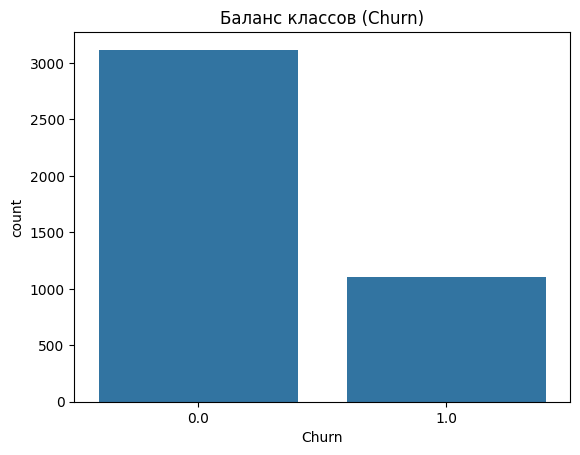

In [118]:
print("Распределение классов в обучающей выборке:")
print(y_train.value_counts(normalize=True))

sns.countplot(x=y_train)
plt.title('Баланс классов (Churn)')
plt.show()

In [119]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(
    sampling_strategy='auto',  # Стратегия выборки. 'auto' означает увеличение меньшего класса до размера большинственного.
    random_state=None,         # Зерно для генератора случайных чисел.
    k_neighbors=5,             # Количество ближайших соседей для создания синтетических примеров.
)

X_resampled, y_resampled = smote.fit_resample(X_train, y_train)

In [120]:
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
import copy
import torch

In [181]:
class ChurnDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [185]:
X_train_tensor = torch.tensor(X_resampled.to_numpy(), dtype=torch.float32)
y_train_tensor = torch.tensor(y_resampled.to_numpy(), dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test.to_numpy(), dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.float32).unsqueeze(1)

train_dataset = ChurnDataset(X_train_tensor, y_train_tensor)
test_dataset = ChurnDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=1024, shuffle=False)

In [186]:
class MLP(nn.Module):
    def __init__(
        self,
        in_features,
        hidden_layers=[128, 64, 32],
        dropout_rate=0.3,
        use_bn=True,
        activation='relu'
    ):
        super().__init__()
        layers = []
        
        for units in hidden_layers:
            layers.append(nn.Linear(in_features, units))
            if use_bn:
                layers.append(nn.BatchNorm1d(units))
            if activation == 'relu':
                layers.append(nn.ReLU())
            elif activation == 'leaky_relu':
                layers.append(nn.LeakyReLU())
            layers.append(nn.Dropout(dropout_rate))
            in_features = units

        layers.append(nn.Linear(in_features, 1))
        layers.append(nn.Sigmoid())
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [187]:
class EarlyStopping:
    def __init__(self, patience=10, delta=0.0, mode='max'):
        self.patience = patience
        self.delta = delta
        self.mode = mode
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, score):
        if self.best_score is None:
            self.best_score = score
        elif (self.mode == 'max' and score < self.best_score + self.delta) or \
             (self.mode == 'min' and score > self.best_score - self.delta):
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.counter = 0

In [190]:
def train_mlp(
    model,
    train_loader,
    test_loader,
    X_test_tensor,
    y_test_tensor,
    optimizer,
    criterion,
    n_epochs=200,
    patience=15
):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    X_test_tensor = X_test_tensor.to(device)
    y_test_tensor = y_test_tensor.to(device)

    early_stopping = EarlyStopping(patience=patience, mode='max')
    best_model = None
    history = {'train_loss': [], 'val_auc': []}

    for epoch in range(n_epochs):
        model.train()
        total_loss = 0
        for X_batch, y_batch in train_loader:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()

        # Валидация
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test_tensor).cpu().numpy().ravel()
            y_true = y_test_tensor.cpu().numpy().ravel()
            val_auc = roc_auc_score(y_true, y_pred)

        avg_loss = total_loss / len(train_loader)
        history['train_loss'].append(avg_loss)
        history['val_auc'].append(val_auc)

        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d} | Loss: {avg_loss:.4f} | Val AUC: {val_auc:.4f}")

        early_stopping(val_auc)
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
        if early_stopping.best_score == val_auc:
            best_model = copy.deepcopy(model.state_dict())

    if best_model is not None:
        model.load_state_dict(best_model)
    return model, history

In [192]:
# Инициализация модели
input_dim = X_test.shape[1]
model = MLP(
    in_features=input_dim,
    hidden_layers=[128, 64, 32],
    dropout_rate=0.4,
    use_bn=True,
    activation='relu'
)

# Оптимизатор и функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
# Альтернативы: torch.optim.RMSprop, torch.optim.SGD с momentum
criterion = nn.BCELoss()

# Обучение
trained_model, history = train_mlp(
    model, train_loader, test_loader, X_test_tensor, y_test_tensor,
    optimizer, criterion, n_epochs=200, patience=15
)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# Финальная оценка
trained_model.eval()
with torch.no_grad():
    y_pred_final = trained_model(X_test_tensor.to(device)).cpu().numpy().ravel()
    y_true_final = y_test_tensor.cpu().numpy().ravel()
    final_auc = roc_auc_score(y_true_final, y_pred_final)
    print(f"\nFinal Test ROC-AUC: {final_auc:.4f}")

Epoch   0 | Loss: 0.5692 | Val AUC: 0.8395
Epoch  10 | Loss: 0.4527 | Val AUC: 0.8539
Epoch  20 | Loss: 0.4390 | Val AUC: 0.8521
Early stopping triggered.

Final Test ROC-AUC: 0.8547


In [207]:
submission = pd.read_csv('submission.csv')

submission['Churn'] = trained_model(torch.Tensor(df_test.drop(columns=['Churn']).astype("float64").to_numpy()).to(device)).to('cpu').detach().numpy()

In [208]:
submission.to_csv('fourth_pred.csv', index=False)

In [114]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score

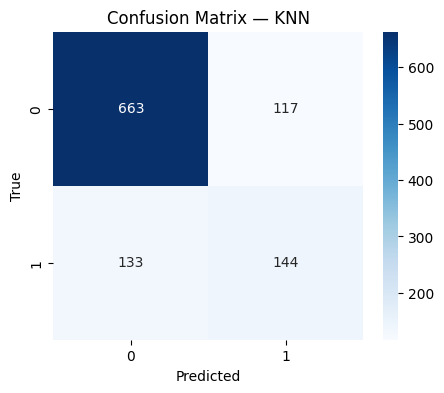

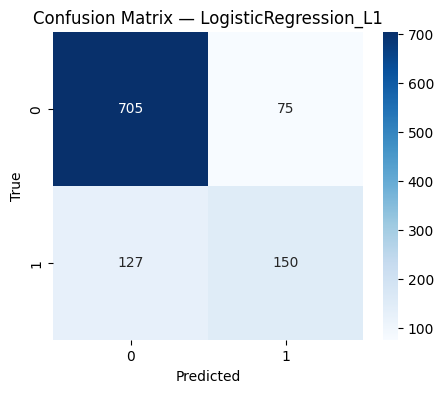

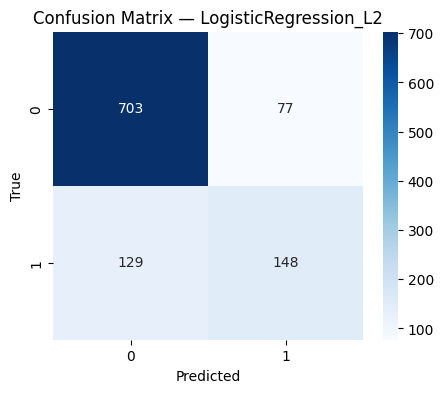

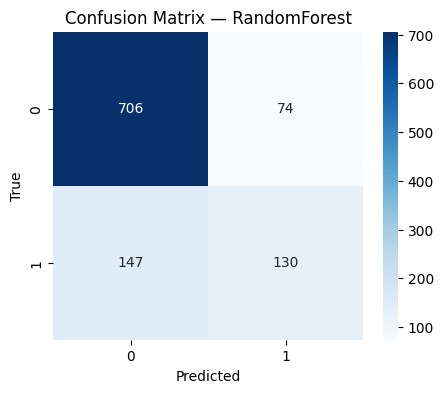

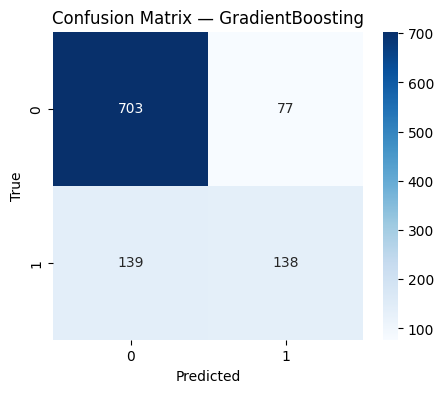

Learning rate set to 0.019062
0:	learn: 0.6803117	total: 151ms	remaining: 2m 30s
1:	learn: 0.6672928	total: 153ms	remaining: 1m 16s
2:	learn: 0.6554062	total: 155ms	remaining: 51.5s
3:	learn: 0.6429334	total: 157ms	remaining: 39.1s
4:	learn: 0.6315671	total: 159ms	remaining: 31.7s
5:	learn: 0.6218933	total: 161ms	remaining: 26.7s
6:	learn: 0.6122735	total: 163ms	remaining: 23.1s
7:	learn: 0.6033973	total: 165ms	remaining: 20.5s
8:	learn: 0.5942884	total: 167ms	remaining: 18.4s
9:	learn: 0.5858903	total: 169ms	remaining: 16.7s
10:	learn: 0.5787771	total: 171ms	remaining: 15.4s
11:	learn: 0.5714193	total: 173ms	remaining: 14.3s
12:	learn: 0.5652734	total: 175ms	remaining: 13.3s
13:	learn: 0.5587857	total: 177ms	remaining: 12.5s
14:	learn: 0.5527351	total: 179ms	remaining: 11.8s
15:	learn: 0.5468700	total: 181ms	remaining: 11.2s
16:	learn: 0.5411757	total: 184ms	remaining: 10.6s
17:	learn: 0.5349693	total: 186ms	remaining: 10.1s
18:	learn: 0.5299963	total: 188ms	remaining: 9.69s
19:	learn

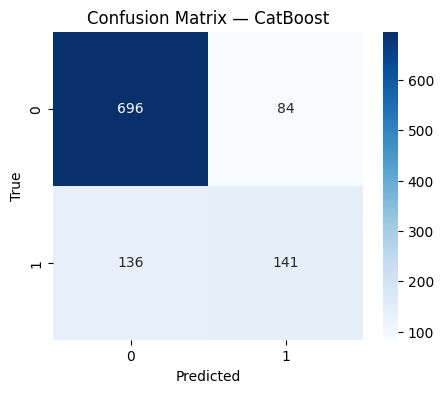


Сравнение моделей:
                       Accuracy  Precision  Recall  F1-score  Roc-Auc
KNN                       0.763      0.552   0.520     0.535    0.225
LogisticRegression_L1     0.809      0.667   0.542     0.598    0.145
LogisticRegression_L2     0.805      0.658   0.534     0.590    0.145
RandomForest              0.791      0.637   0.469     0.541    0.171
GradientBoosting          0.796      0.642   0.498     0.561    0.151
CatBoost                  0.792      0.627   0.509     0.562    0.158


In [ ]:
# 8. Обучение моделей
models = {
    'KNN': KNeighborsClassifier(),
    'LogisticRegression_L1': LogisticRegression(penalty='l1', solver='liblinear', max_iter=1000),
    'LogisticRegression_L2': LogisticRegression(penalty='l2', solver='liblinear', max_iter=1000),
    'RandomForest': RandomForestClassifier(random_state=42),
    'GradientBoosting': GradientBoostingClassifier(random_state=42),
    'CatBoost': CatBoostClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    # Обучение
    model.fit(X_train, y_train)
    # Предсказание
    y_pred = model.predict(X_test)
    
    # Метрики
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 0])
    
    results[name] = {'Accuracy': acc, 'Precision': prec, 'Recall': rec, "F1-score": f1, "Roc-Auc": roc_auc}
    
    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix — {name}')
    plt.ylabel('True')
    plt.xlabel('Predicted')
    plt.show()

# 9. Вывод результатов
results_df = pd.DataFrame(results).T
print("\nСравнение моделей:")
print(results_df.round(3))

In [113]:
top_models = ['LogisticRegression_L1', 'LogisticRegression_L2', 'GradientBoosting']

In [ ]:
from scipy.stats import randint, uniform

# Словарь с параметрами для RandomizedSearchCV
param_grids = {
    'GradientBoosting': {
        'n_estimators': randint(50, 300),
        'max_depth': randint(3, 20),
        'min_samples_split': randint(2, 20),
        'min_samples_leaf': randint(1, 10)
    },
    'LogisticRegression_L2': {
        'C': uniform(0.01, 10),
        'penalty': ['l2'],
        'solver': ['liblinear']
    },
    'LogisticRegression_L1': {
        'C': uniform(0.01, 10),
        'penalty': ['l1'],
        'solver': ['liblinear']
    }
}

best_models = {}

for name in top_models:
    if name not in param_grids:
        continue

    print(f"\nTuning hyperparameters for {name}...")

    X_train_use = X_train

    model = models[name]
    search = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_grids[name],
        n_iter=50,
        scoring='roc_auc',
        cv=5,
        random_state=42,
        n_jobs=-1
    )
    search.fit(X_train_use, y_train)

    best_models[name] = search.best_estimator_
    print(f"Best parameters for {name}: {search.best_params_}")
    print(f"Best CV ROC-AUC: {search.best_score_:.4f}")


Tuning hyperparameters for LogisticRegression_L1...
Best parameters for LogisticRegression_L1: {'C': 5.210680211778108, 'penalty': 'l1', 'solver': 'liblinear'}
Best CV ROC-AUC: 0.8411

Tuning hyperparameters for LogisticRegression_L2...
Best parameters for LogisticRegression_L2: {'C': 3.0561376917337064, 'penalty': 'l2', 'solver': 'liblinear'}
Best CV ROC-AUC: 0.8411

Tuning hyperparameters for GradientBoosting...
Best parameters for GradientBoosting: {'max_depth': 3, 'min_samples_leaf': 6, 'min_samples_split': 13, 'n_estimators': 138}
Best CV ROC-AUC: 0.8388


In [117]:
print("\nFinal test ROC-AUC scores:")
for name, best_model in best_models.items():

    y_pred_proba = best_model.predict_proba(X_test)[:, 1]
    test_roc_auc = roc_auc_score(y_test, y_pred_proba)
    print(f"{name} (tuned): ROC-AUC = {test_roc_auc:.4f}")


Final test ROC-AUC scores:
LogisticRegression_L1 (tuned): ROC-AUC = 0.8555
LogisticRegression_L2 (tuned): ROC-AUC = 0.8555
GradientBoosting (tuned): ROC-AUC = 0.8472


In [118]:
sorted(zip(best_models['LogisticRegression_L1'].coef_[0], X.columns), key=lambda x: abs(x[0]), reverse=True)

[(-1.4701087317396753, 'HasContractPhone_Two year'),
 (-1.0327301763598453, 'ClientPeriod'),
 (0.7471201946986185, 'HasInternetService_Fiber optic'),
 (-0.6285899484611328, 'HasContractPhone_One year'),
 (-0.46793122321323366, 'HasOnlineSecurityService_Yes'),
 (0.3890158789054339, 'HasInternet'),
 (0.37314347376930584, 'IsBillingPaperless_Yes'),
 (0.3636098751683321, 'HasMultiplePhoneNumbers_Yes'),
 (0.32927008595232204, 'PaymentMethod_Electronic check'),
 (-0.3192264076096876, 'HasTechSupportAccess_Yes'),
 (0.3122828129439639, 'HasOnlineTV_Yes'),
 (0.3041516138390447, 'IsLongTerm'),
 (-0.2891871357069776, 'HasPhoneService_Yes'),
 (-0.1817748573724037, 'PaymentMethod_Credit card (automatic)'),
 (0.16246696883490921, 'HasMovieSubscription_Yes'),
 (-0.16233828997007957, 'HasOnlineBackup_Yes'),
 (0.1407388906581022, 'IsSeniorCitizen'),
 (-0.060487033173625, 'Sex_Male'),
 (-0.03663850359268508, 'HasPartner_Yes'),
 (-0.035225030333405696, 'HasChild_Yes'),
 (0.014454597578149878, 'NumAddServ

1. Инсайты разведочного анализа данных (EDA)
Анализ датасета выявил ключевые закономерности, связанные с оттоком клиентов. Во-первых, наблюдается сильная зависимость оттока от срока обслуживания (ClientPeriod): клиенты с ClientPeriod менее 10 месяцев уходят значительно чаще, чем долгосрочные. Во-вторых, высокие ежемесячные платежи (MonthlySpending) также коррелируют с повышенным риском оттока. В-третьих, тип контракта оказался одним из самых информативных категориальных признаков: клиенты с помесячным контрактом (Month-to-month) демонстрируют долю оттока около 40%, в то время как у клиентов с годовым или двухлетним контрактом отток не превышает 5–10%. 

2. Выбор и обоснование модели
Для решения задачи бинарной классификации были протестированы логистическая регрессия, случайный лес и дерево решений. Основной метрикой выбран Recall, так как в бизнес-контексте критичнее минимизировать пропуск реальных случаев оттока (False Negative), чем избегать ложных срабатываний. Лучший Recall (≈0.534) и F1-score (≈0.586) показала модель логистической регрессии. 

3. Интерпретация важности признаков
Анализ важности признаков в модели случайного леса показал следующее. Наибольший вклад в прогноз оттока вносит тип контракта (HasContractPhone_Two year), что согласуется с выводами EDA. Вторым по значимости оказался срок обслуживания (ClientPeriod) — чем он короче, тем выше вероятность ухода. Третьим важным признаком стала ежемесячная плата (MonthlySpending), особенно в сочетании с отсутствием долгосрочного контракта. Также значимыми оказались такие признаки, как тип интренет сервиса (HasInternetService), наличие онлайн сервиса защиты (HasOnlineSecurityService) и общая сумма расходов (TotalCharges), которая косвенно отражает лояльность клиента. Эти результаты подтверждают гипотезу: клиенты, не связанные контрактом, с высокими платежами и минимальным набором дополнительных услуг, представляют собой группу повышенного риска оттока.

Полученные инсайты позволяют рекомендовать бизнесу целевые меры: стимулирование перехода на годовые контракты, персонализированные предложения по снижению MonthlyCharges для новых клиентов и продвижение сервисов техподдержки и резервного копирования как инструментов удержания.

In [119]:
best_model = best_models['LogisticRegression_L1']
submission = pd.read_csv('submission.csv')

submission['Churn'] = 1 - best_model.predict_proba(df_test.drop('Churn', axis=1))

In [120]:
submission.to_csv('third_pred.csv', index=False) # Score: 0.84435